In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from partition_decode.plots import continuous_pairplot
from scipy.stats import spearmanr, kendalltau, entropy
from matplotlib.colors import SymLogNorm, LogNorm, Normalize

sns.set_style('white')
sns.set_context('notebook')

In [2]:
#
algo = "relu_regressor"
dataset = "mnist"

# Read
df = pd.read_csv(f'./varying_model_results/{dataset}/{dataset}_{algo}_belkin_kernel_results.csv', index_col=0)
df = df[df['total_epochs'] > 0]

# Define headers
metric = "01_error"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

In [3]:
# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df["IRM_cols_mean_L1"] = df["IRM_cols_mean_L1"] / df["n_train_samples"]
df["IRM_cols_mean_L2"] = df["IRM_cols_mean_L2"] / df["n_train_samples"]
df['IRM_L1'] = df["IRM_L1"] / df["n_train_samples"]

# Average across reps
# df = df.groupby(
#     ['hidden_layer_dims', "n_epochs"],
#     as_index=False,
# ).mean()
for col in ['n_parameters', 'hidden_layer_dims', 'n_epochs', "total_epochs"]:
    df[col] = df[col].astype(int)

df.head(5)

,rep,n_train_samples,n_test_samples,save_path,onehot,shuffle_label_frac,hidden_layer_dims,n_epochs,learning_rate,batch_size,...,n_parameters,depth,width,total_epochs,weights_L2,mean_affine_mat_norm,kernel_trace,head_norm,OLS_norm,generalization_gap
model,,,,,,,,,,,,,,,,,,,,,
relu_regressor,0.0,4000.0,10000.0,/mnt/ssd3/ronan/pytorch,1.0,None,4,10,0.01,32.0,...,3190,1.0,4.0,10,2.834809,14.936015,0.725412,1.275934,0.236022,0.01195
relu_regressor,0.0,4000.0,10000.0,/mnt/ssd3/ronan/pytorch,1.0,None,4,40,0.01,32.0,...,3190,1.0,4.0,50,2.826745,19.063370,0.711724,1.195826,0.216757,0.01575
relu_regressor,0.0,4000.0,10000.0,/mnt/ssd3/ronan/pytorch,1.0,None,4,50,0.01,32.0,...,3190,1.0,4.0,100,2.826133,20.014772,0.710670,1.198395,0.218667,0.01810
relu_regressor,0.0,4000.0,10000.0,/mnt/ssd3/ronan/pytorch,1.0,None,4,100,0.01,32.0,...,3190,1.0,4.0,200,2.829715,20.580970,0.711203,1.214578,0.223741,0.01960
relu_regressor,0.0,4000.0,10000.0,/mnt/ssd3/ronan/pytorch,1.0,None,4,300,0.01,32.0,...,3190,1.0,4.0,500,2.854114,20.416656,0.711686,1.221604,0.231400,0.00915


## Errors

In [9]:
df.groupby(
    ['hidden_layer_dims', "total_epochs"],
    as_index=False,
).mean().pivot("total_epochs", "hidden_layer_dims", train_error)

hidden_layer_dims,4,8,12,16,24,32,38,42,46,50,51,64,128,256,512,1024
total_epochs,,,,,,,,,,,,,,,,
10,0.752833,0.610833,0.502417,0.455333,0.320583,0.071250,0.018583,0.016833,0.016333,0.015500,0.107583,0.087333,0.074917,0.056250,0.040167,0.031083
50,0.756333,0.586417,0.499750,0.436917,0.305250,0.059250,0.018333,0.016833,0.016250,0.015583,0.104750,0.093417,0.069417,0.053667,0.039583,0.029583
100,0.756250,0.577417,0.510917,0.423000,0.299583,0.057917,0.018250,0.016833,0.016250,0.015667,0.104250,0.091583,0.072250,0.051333,0.042417,0.032000
200,0.755417,0.569333,0.520000,0.411000,0.248750,0.056750,0.018250,0.016833,0.016250,0.015667,0.074833,0.071083,0.055167,0.037917,0.024833,0.017083
500,0.721583,0.590000,0.519417,0.396083,0.216333,0.026250,0.018000,0.016750,0.016167,0.015583,0.045333,0.038167,0.021667,0.009500,0.005250,0.001417
1000,0.720500,0.589250,0.518333,0.394667,0.155333,0.024083,0.017917,0.016750,0.016167,0.015500,0.031083,0.025000,0.012833,0.005500,0.001417,0.000250
2000,0.714167,0.587417,0.517250,0.393750,0.149083,0.022750,0.017500,0.016667,0.016167,0.015500,0.015417,0.013167,0.004583,0.000750,0.000000,0.000000
3000,0.714667,0.586917,0.517000,0.393500,0.148167,0.020167,0.017167,0.016583,0.016167,0.015333,0.018750,0.012167,0.005333,0.000917,0.000000,0.000000
6000,0.716250,0.586917,0.485417,0.392917,0.145667,0.018333,0.016833,0.016250,0.015583,0.014667,0.008667,0.005500,0.001500,0.000000,0.000000,0.000000


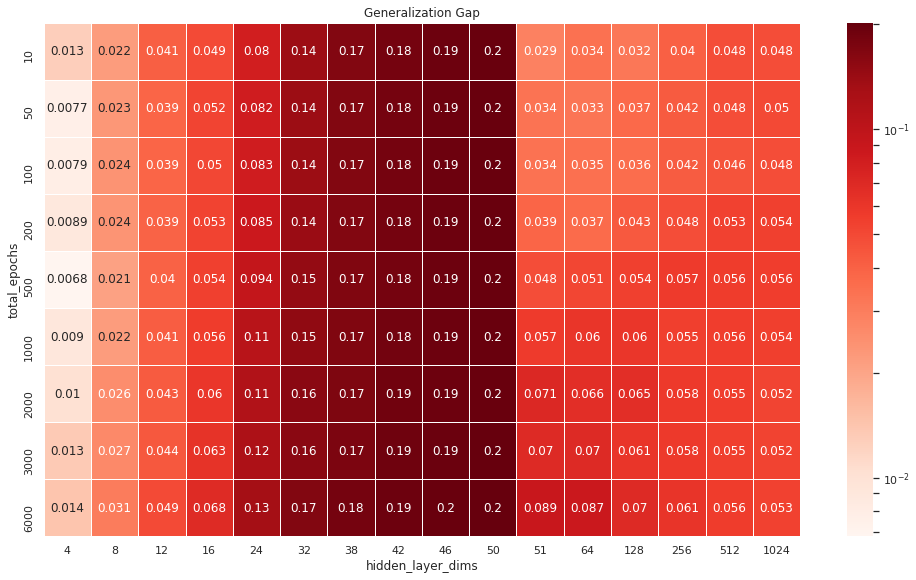

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
sns.heatmap(
    data=df.groupby(
        ['hidden_layer_dims', "total_epochs"],
        as_index=False,
    ).mean().pivot("total_epochs", "hidden_layer_dims", "generalization_gap"),
    linewidths=.5,
    ax=ax,
    cmap='Reds',
    norm=SymLogNorm(1e-3),
    annot=True, fmt=".2",
)
plt.tight_layout()
plt.title('Generalization Gap')
plt.show()

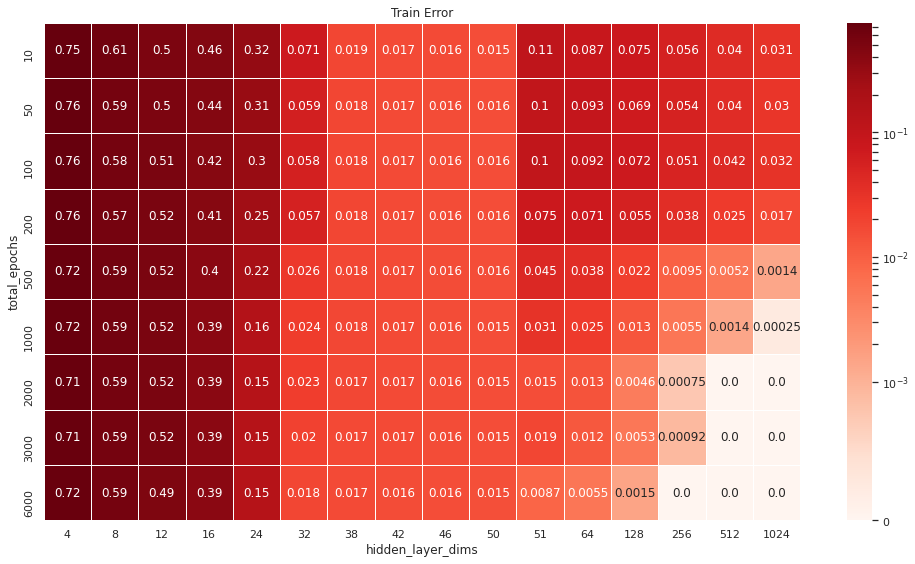

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
sns.heatmap(
    data=df.groupby(
        ['hidden_layer_dims', "total_epochs"],
        as_index=False,
    ).mean().pivot("total_epochs", "hidden_layer_dims", train_error),
    linewidths=.5,
    ax=ax,
    cmap='Reds',
    norm=SymLogNorm(1e-3),
    annot=True, fmt=".2",
)
plt.title('Train Error')
plt.tight_layout()
plt.show()

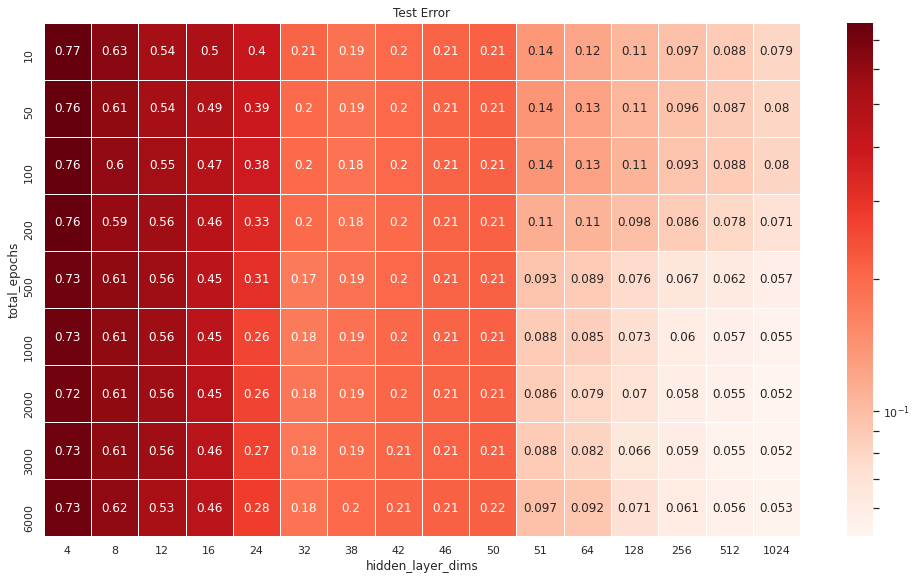

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
sns.heatmap(
    data=df.groupby(
        ['hidden_layer_dims', "total_epochs"],
        as_index=False,
    ).mean().pivot("total_epochs", "hidden_layer_dims", test_error),
    linewidths=.5,
    ax=ax,
    cmap='Reds',
    norm=SymLogNorm(1e-3),
    annot=True, fmt=".2",
)
plt.tight_layout()
plt.title('Test Error')
plt.show()

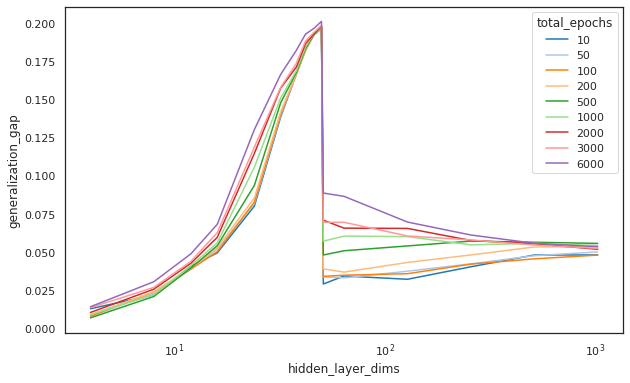

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.lineplot(
    data=df, hue='total_epochs', y="generalization_gap",
    x='hidden_layer_dims', palette='tab20', ax=ax, ci=None)
plt.xscale('log')
plt.show()

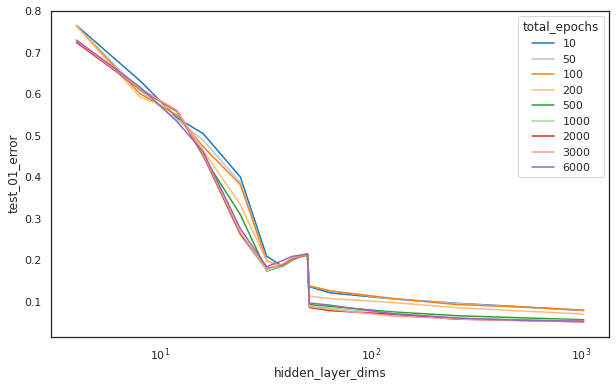

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.lineplot(
    data=df, hue='total_epochs', y=test_error,
    x='hidden_layer_dims', palette='tab20', ax=ax, ci=None)
plt.xscale('log')
plt.show()

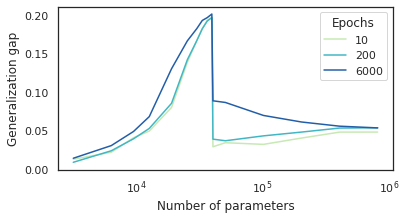

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
sns.lineplot(
    data=df[df['total_epochs'].isin([10, 200, 6000])],
    hue='total_epochs',
    y="generalization_gap",
    x='n_parameters',
    palette=["#c7e9b4", "#41b6c4", "#225ea8"],
    ax=ax,
    legend=False,
    ci=None)
plt.xscale('log')
plt.xlabel('Number of parameters')
plt.ylabel('Generalization gap')
plt.xscale('log')
plt.legend(title='Epochs', labels=[10, 200, 6000])
plt.savefig('./figures/relu_regressor_gen_epochs_belkin.pdf')
plt.show()

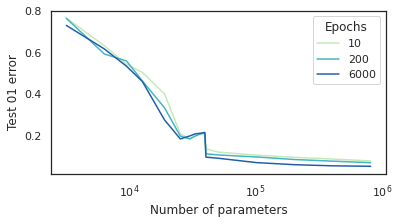

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
sns.lineplot(
    data=df[df['total_epochs'].isin([10, 200, 6000])],
    hue='total_epochs',
    y=test_error,
    x='n_parameters',
    palette=["#c7e9b4", "#41b6c4", "#225ea8"],
    ax=ax,
    legend=False,
    ci=None)
plt.xscale('log')
plt.xlabel('Number of parameters')
plt.ylabel('Test 01 error')
plt.xscale('log')
plt.legend(title='Epochs', labels=[10, 200, 6000])
plt.savefig('./figures/relu_regressor_test_epochs_belkin.pdf')
plt.show()

## Metrics

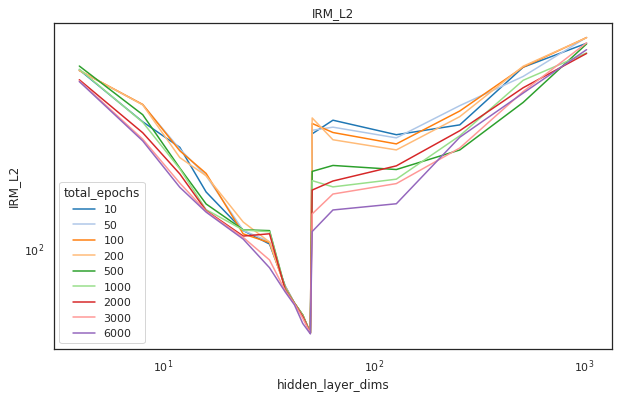

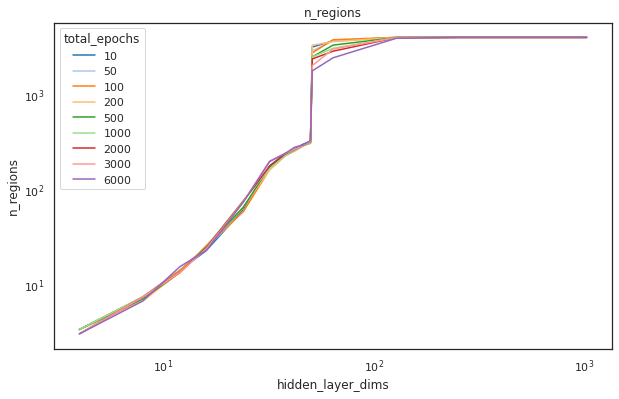

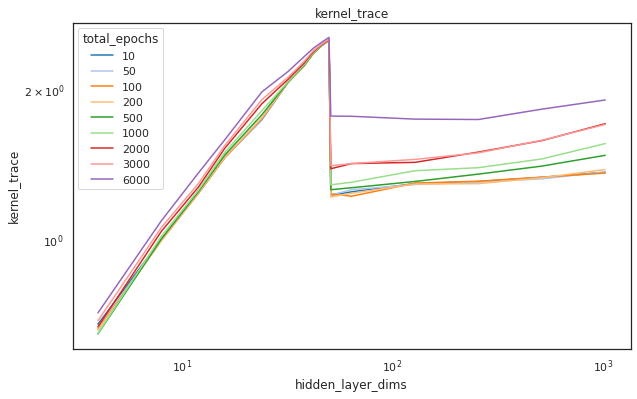

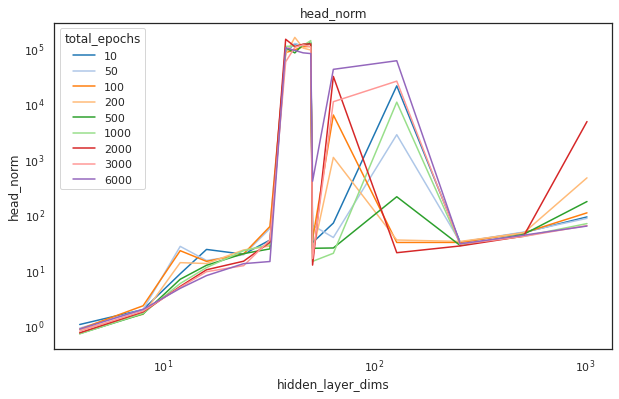

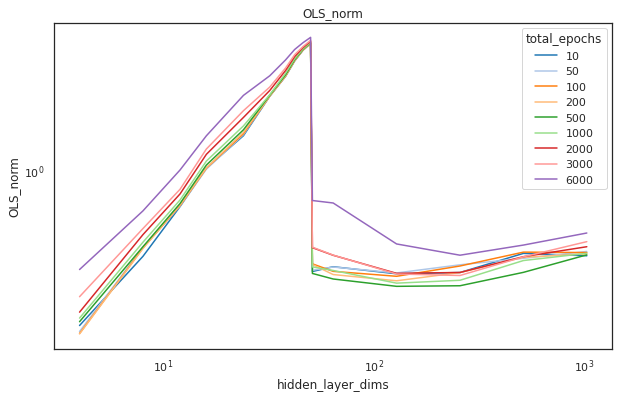

In [108]:
corr_vars = [
    # 'generalization_gap', # test_error,
    # 'n_parameters', 'width',
    # 'IRM_L1',
    'IRM_L2', 'n_regions',
    # 'ACTS_L2',
    # 'IRM_h*', 'ACTS_h*',
    # 'IRM_entropy', 'IRM_entropy_normalized',
    # 'IRM_rows_mean_L2_min',
    # 'IRM_rows_mean_L2_max',
    # 'IRM_rows_mean_L2',
    # 'IRM_rows_mean_L2_normalized_min',
    # 'IRM_rows_mean_L2_normalized_max',
    # 'IRM_cols_mean_L1', 'IRM_cols_mean_L2',
    # 'IRM_mean_dot_product', 'IRM_mean_sim_entropy',
    'kernel_trace', 'head_norm', 'OLS_norm',
]
for metric in corr_vars:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    sub_df=df.copy()
    if metric == 'head_norm':
        sub_df[metric] = sub_df[metric] / np.sqrt(sub_df['hidden_layer_dims'])
    sns.lineplot(
        data=sub_df,
        hue='total_epochs',
        y=metric,
        x='hidden_layer_dims',
        ci=None,
        palette='tab20', ax=ax)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(metric)
    plt.show()

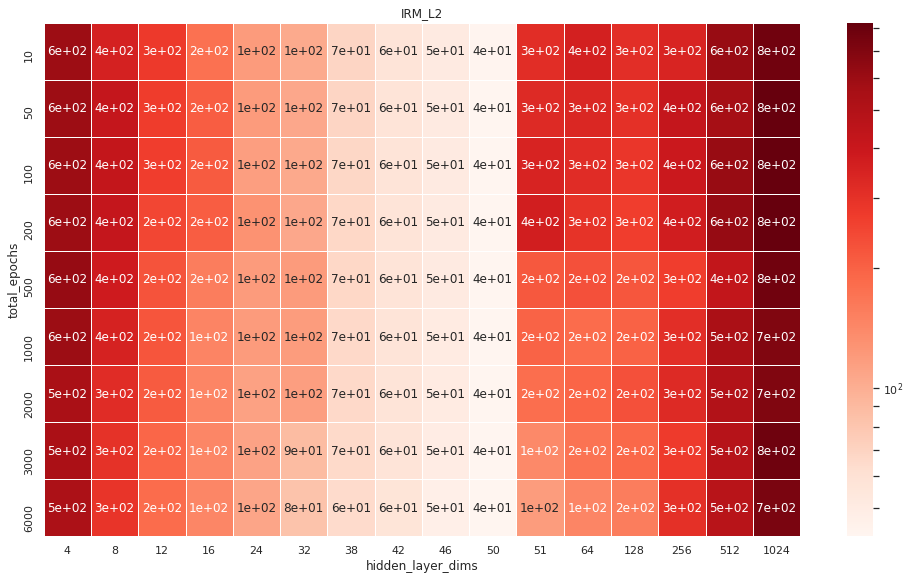

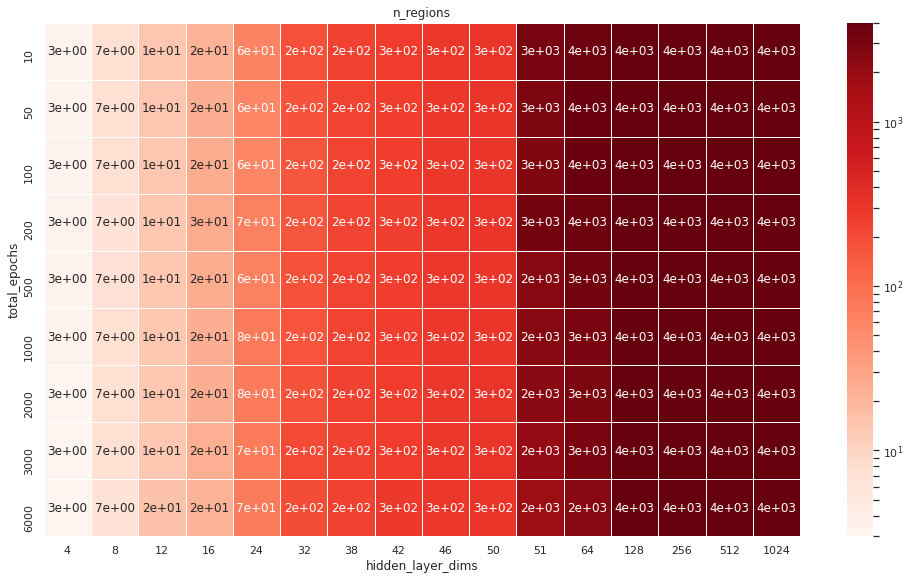

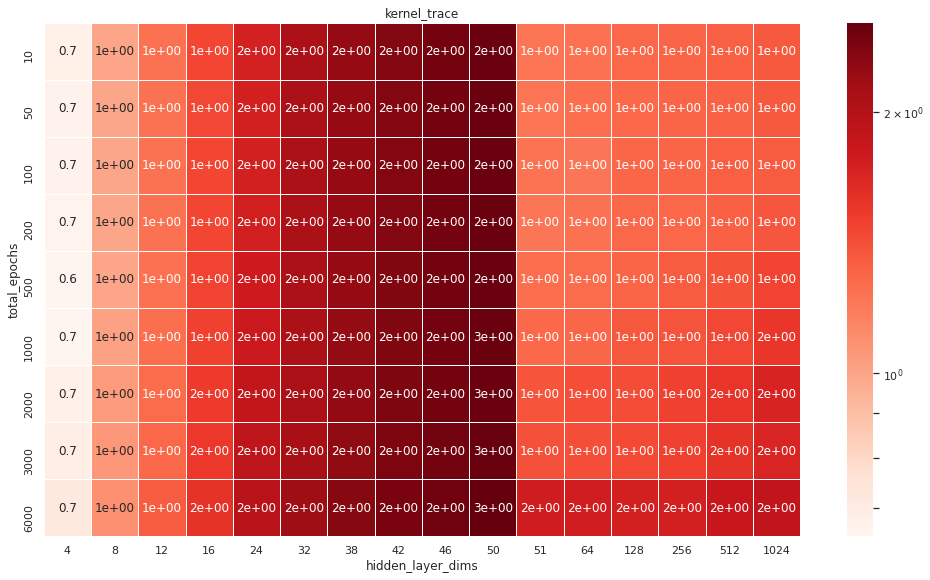

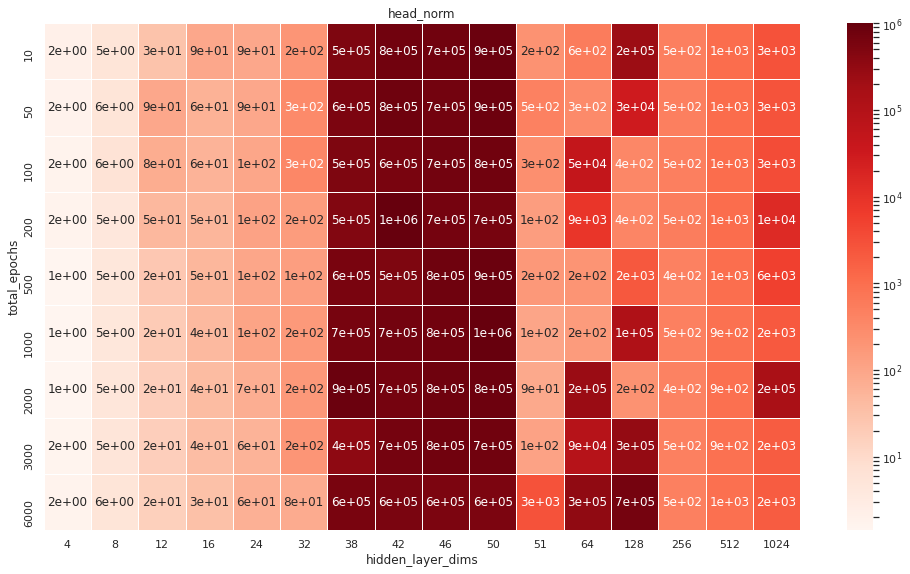

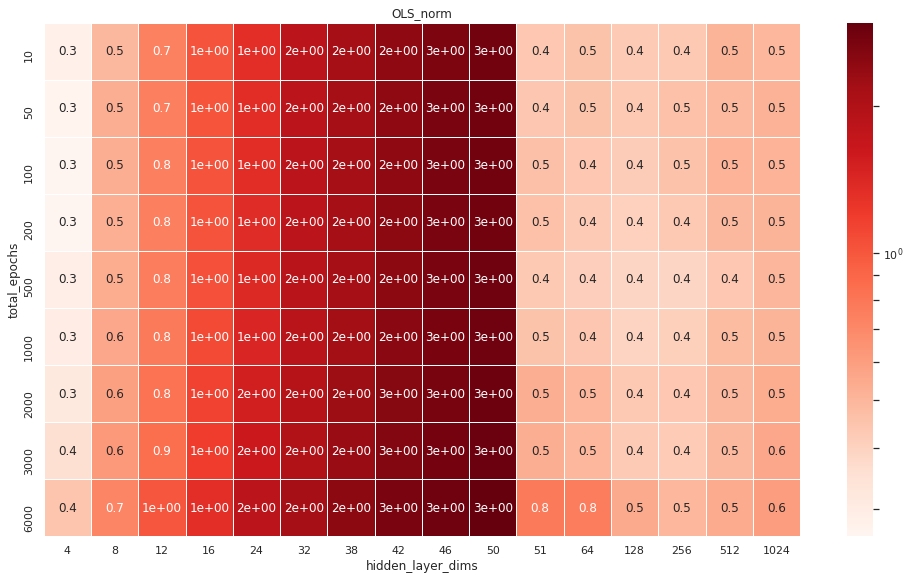

In [20]:
corr_vars = [
    # 'generalization_gap', # test_error,
    # 'n_parameters', 'width',
    # 'IRM_L1',
    'IRM_L2', 'n_regions',
    # 'ACTS_L2',
    # 'IRM_h*', 'ACTS_h*',
    # 'IRM_entropy', 'IRM_entropy_normalized',
    # 'IRM_rows_mean_L2_min',
    # 'IRM_rows_mean_L2_max',
    # 'IRM_rows_mean_L2',
    # 'IRM_rows_mean_L2_normalized_min',
    # 'IRM_rows_mean_L2_normalized_max',
    # 'IRM_cols_mean_L1', 'IRM_cols_mean_L2',
    # 'IRM_mean_dot_product', 'IRM_mean_sim_entropy',
    'kernel_trace', 'head_norm', 'OLS_norm',
]
for metric in corr_vars:
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    sns.heatmap(
        data=df.groupby(
            ['hidden_layer_dims', "total_epochs"],
            as_index=False,
        ).mean().pivot("total_epochs", "hidden_layer_dims", metric),
        linewidths=.5,
        ax=ax,
        cmap='Reds',
        norm=SymLogNorm(1e-3),
        annot=True, fmt=".1",
    )
    plt.tight_layout()
    plt.title(metric)
    plt.show()

## level sets and overall

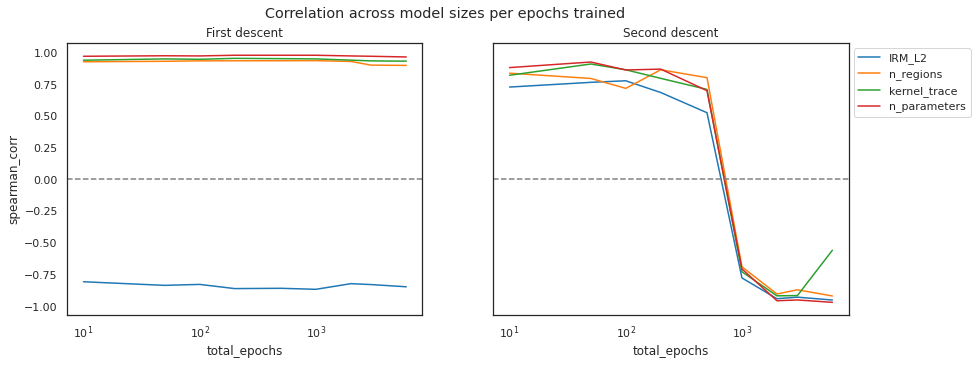

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

interp_var = 'n_parameters'
interp = 10*df['n_train_samples'].iloc[0]
for ax, idx, title in zip(
        axes,
        (
            df[interp_var] <= interp,
            df[interp_var] >= interp,
            # df[interp_var] >= 0,
        ),
        ('First descent', 'Second descent')
    ):

    target_var = 'total_epochs'
    sub_vars = [
        'IRM_L2',
        'n_regions',
        'kernel_trace',
        'n_parameters',
        'generalization_gap',
    ]
    corr_df = df[idx][[target_var] + sub_vars].groupby([target_var]).corr('spearman').reset_index()
    corr_df = corr_df[corr_df['level_1'] == 'generalization_gap']

    g = sns.lineplot(
        data=corr_df.melt(
            id_vars=target_var,
            value_vars=sub_vars[:-1],
            var_name='metric',
            value_name='spearman_corr'),
        hue='metric',
        y='spearman_corr',
        x=target_var,
        ax=ax)
    g.get_legend().remove()
    ax.axhline(0, ls='--', c='grey')
    ax.set_xscale('log')
    ax.set_title(title)
axes[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.suptitle('Correlation across model sizes per epochs trained')
plt.show()

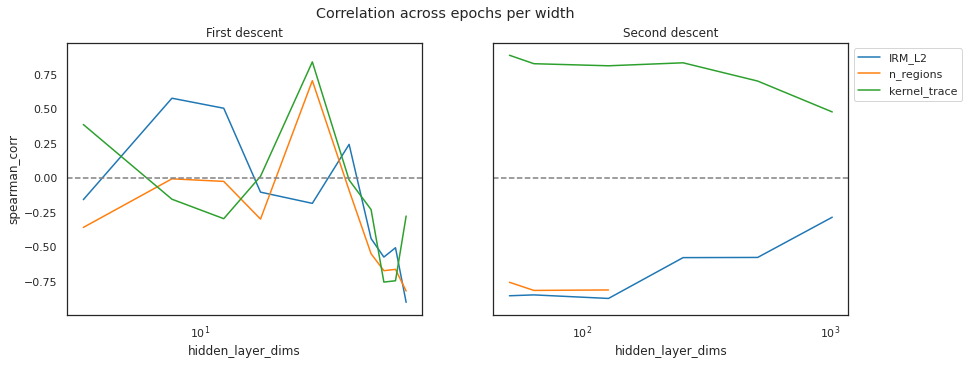

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

interp_var = 'n_parameters'
interp = 10*df['n_train_samples'].iloc[0]

target_var = 'hidden_layer_dims'
sub_vars = [
    'IRM_L2',
    'n_regions',
    'kernel_trace',
    # 'n_parameters',
    'generalization_gap',
]
    
for ax, idx, title in zip(
        axes,
        (
            df[interp_var] <= interp,
            df[interp_var] >= interp,
            # df[interp_var] >= 0,
        ),
        ('First descent', 'Second descent')
    ):

    corr_df = df[idx][[target_var] + sub_vars].groupby([target_var]).corr('spearman').reset_index()
    corr_df = corr_df[corr_df['level_1'] == 'generalization_gap']

    g = sns.lineplot(
        data=corr_df.melt(
            id_vars=target_var,
            value_vars=sub_vars[:-1],
            var_name='metric',
            value_name='spearman_corr'),
        hue='metric',
        y='spearman_corr',
        x=target_var,
        ax=ax)
    g.get_legend().remove()
    ax.axhline(0, ls='--', c='grey')
    ax.set_xscale('log')
    ax.set_title(title)
axes[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.suptitle('Correlation across epochs per width')
plt.show()